# BentoML Example: Keras Fashion MNIST

[BentoML](http://bentoml.ai) is an open source platform for machine learning model serving and deployment. 

This notebook demonstrates how to use BentoML to turn a Keras model into a docker image containing a REST API server serving this model, how to use your ML service built with BentoML as a CLI tool, and how to distribute it a pypi package.

![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=keras&ea=keras-fashion-mnist&dt=keras-fashion-mnist)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#!pip install bentoml
!pip install tensorflow==1.14.0 numpy matplotlib keras

     |████████████████████████████████| 105.8 MB 25.8 MB/s eta 0:00:01
  Using cached tensorflow_estimator-1.14.0-py2.py3-none-any.whl (488 kB)
  Using cached tensorboard-1.14.0-py3-none-any.whl (3.1 MB)
ERROR: fashionmnisttensorflow 20200123104656-1FC32A has requirement bentoml==0.6.0, but you'll have bentoml 0.6.1+4.gd82c2f1 which is incompatible.
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.0.1
    Uninstalling tensorflow-estimator-2.0.1:
      Successfully uninstalled tensorflow-estimator-2.0.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.0.2
    Uninstalling tensorboard-2.0.2:
      Successfully uninstalled tensorboard-2.0.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.0.0
    Uninstalling tensorflow-2.0.0:
      Successfully uninstalled tensorflow-2.0.0


In [3]:
from __future__ import absolute_import, division, print_function

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print("Tensorflow Version: %s" % tf.__version__)

import keras
print("Keras Version: %s" % keras.__version__)

import bentoml
print("BentoML Version: %s" % bentoml.__version__)

Tensorflow Version: 1.14.0
Keras Version: 2.2.4


Using TensorFlow backend.


BentoML Version: 0.6.1+4.gd82c2f1


## Load Fashion MNIST dataset

In [4]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Each image is mapped to a single label. Since the class names are not included with the dataset, store them here to use later when plotting the images:

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

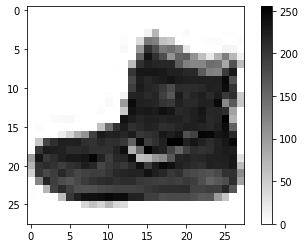

In [6]:
plt.figure()
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

We should scale these values to a range of 0 to 1 before feeding to the neural network model. For this, we divide the values by 255. It's important that the *training set* and the *testing set* are preprocessed in the same way:

In [7]:
train_images = train_images / 255.0
test_images = test_images / 255.0

Display the first 25 images from the training set and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

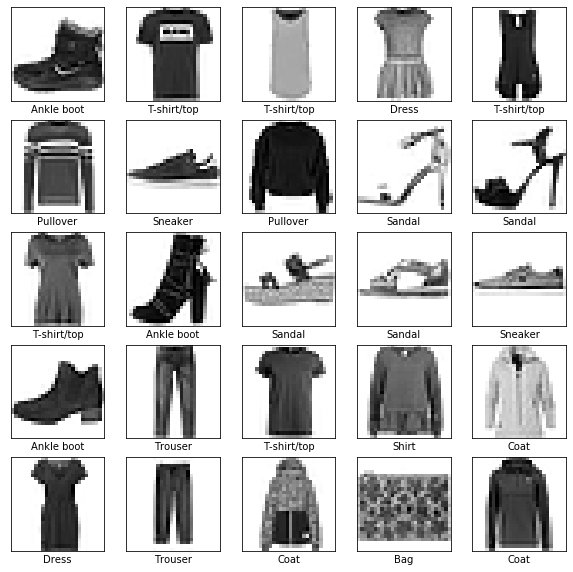

In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [9]:
# Reshaping the images so that our model can accept it
train_images  = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

## Build the model

In [10]:
model = keras.Sequential()
# Must define the input shape in the first layer of the neural network
model.add(keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation='softmax'))
# Take a look at the model summary
model.summary()

W0206 11:26:13.547391 4362923456 deprecation_wrapper.py:119] From /usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0206 11:26:13.561075 4362923456 deprecation_wrapper.py:119] From /usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0206 11:26:13.563452 4362923456 deprecation_wrapper.py:119] From /usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0206 11:26:13.577507 4362923456 deprecation_wrapper.py:119] From /usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
__________

## Compile the model

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

W0206 11:26:13.737553 4362923456 deprecation_wrapper.py:119] From /usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0206 11:26:13.755908 4362923456 deprecation_wrapper.py:119] From /usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3341: The name tf.log is deprecated. Please use tf.math.log instead.



## Train the model

In [12]:
model.fit(train_images, train_labels, batch_size=64, epochs=1)

W0206 11:26:13.888304 4362923456 deprecation.py:323] From /usr/local/anaconda3/envs/dev-py3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
60000/60000 [==============================] - 57s 953us/step - loss: 0.5934 - acc: 0.7827


## Evaluate model accuracy

In [13]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 2s 232us/step
Test accuracy: 0.8571


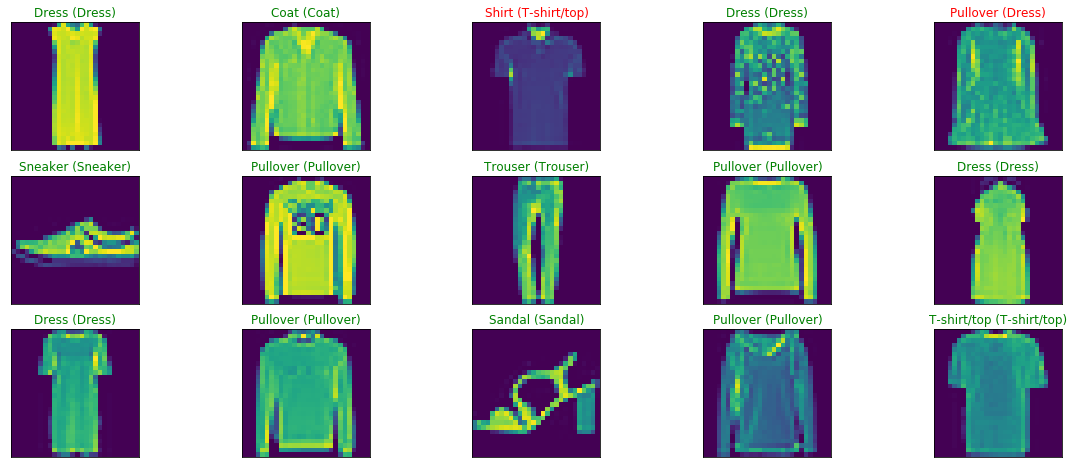

In [14]:
y_hat = model.predict_classes(test_images)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(test_images.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(test_images[index]))
    predict_index = y_hat[index]
    true_index = test_labels[index]
    # Set the title for each image
    ax.set_title("{} ({})".format(class_names[predict_index], 
                                  class_names[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

## Predict on a single image

Let's first see the test image and and its label:

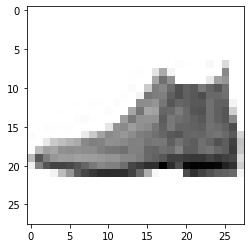

Class: Ankle boot


In [15]:
plt.imshow(test_images[0].squeeze(-1), cmap=plt.cm.binary)
plt.show()
print('Class:', class_names[test_labels[0]])

In [16]:
pred_idx = model.predict_classes(np.expand_dims(test_images[0], 0))[0]
print('Prediction:', class_names[pred_idx])

Prediction: Ankle boot


## Define BentoService for model serving

In [24]:
%%writefile keras_fashion_mnist.py

import numpy as np
from PIL import Image
from bentoml import api, artifacts, env, BentoService
from bentoml.artifact import KerasModelArtifact
from bentoml.handlers import ImageHandler

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

@env(pip_dependencies=['keras', 'tensorflow==1.14.0', 'Pillow', 'numpy'])
@artifacts([KerasModelArtifact('classifier')])
class KerasFashionMnistService(BentoService):
        
    @api(ImageHandler, pilmode='L')
    def predict(self, img):
        img = Image.fromarray(img).resize((28, 28))
        img /= 255.0
        img = np.array(img.getdata()).reshape((1,28,28,1))
        class_idx = self.artifacts.classifier.predict_classes(img)[0]
        return class_names[class_idx]

Overwriting keras_fashion_mnist.py


## Save BentoService to file archive

In [25]:
# 1) import the custom BentoService defined above
from keras_fashion_mnist import KerasFashionMnistService

# 2) `pack` it with required artifacts
mnist_svc = KerasFashionMnistService()
mnist_svc.pack('classifier', model)

# 3) save your BentoSerivce to file archive
saved_path = mnist_svc.save()

[2020-02-06 11:44:30,671] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.6.1. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml_deploy_version' to a pinned version or your custom BentoML on github, e.g.:'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-02-06 11:44:30,695] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.6.1. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml

no previously-included directories found matching 'examples'
no previously-included directories found matching 'tests'
no previously-included directories found matching 'docs'
no previously-included directories found matching 'scripts'


writing manifest file 'BentoML.egg-info/SOURCES.txt'
running check


creating BentoML-0.6.1+4.gd82c2f1
creating BentoML-0.6.1+4.gd82c2f1/BentoML.egg-info
creating BentoML-0.6.1+4.gd82c2f1/bentoml
creating BentoML-0.6.1+4.gd82c2f1/bentoml/artifact
creating BentoML-0.6.1+4.gd82c2f1/bentoml/bundler
creating BentoML-0.6.1+4.gd82c2f1/bentoml/cli
creating BentoML-0.6.1+4.gd82c2f1/bentoml/clipper
creating BentoML-0.6.1+4.gd82c2f1/bentoml/configuration
creating BentoML-0.6.1+4.gd82c2f1/bentoml/deployment
creating BentoML-0.6.1+4.gd82c2f1/bentoml/deployment/aws_lambda
creating BentoML-0.6.1+4.gd82c2f1/bentoml/deployment/sagemaker
creating BentoML-0.6.1+4.gd82c2f1/bentoml/handlers
creating BentoML-0.6.1+4.gd82c2f1/bentoml/migrations
creating BentoML-0.6.1+4.gd82c2f1/bentoml/migrations/versions
creating BentoML-0.6.1+4.gd82c2f1/bentoml/proto
creating BentoML-0.6.1+4.gd82c2f1/bentoml/repository
creating BentoML-0.6.1+4.gd82c2f1/bentoml/server
creating BentoML-0.6.1+4.gd82c2f1/bentoml/server/static
creating BentoML-0.6.1+4.gd82c2f1/bentoml/utils
creating BentoML-0.6

copying bentoml/server/__init__.py -> BentoML-0.6.1+4.gd82c2f1/bentoml/server
copying bentoml/server/bento_api_server.py -> BentoML-0.6.1+4.gd82c2f1/bentoml/server
copying bentoml/server/bento_sagemaker_server.py -> BentoML-0.6.1+4.gd82c2f1/bentoml/server
copying bentoml/server/gunicorn_config.py -> BentoML-0.6.1+4.gd82c2f1/bentoml/server
copying bentoml/server/gunicorn_server.py -> BentoML-0.6.1+4.gd82c2f1/bentoml/server
copying bentoml/server/middlewares.py -> BentoML-0.6.1+4.gd82c2f1/bentoml/server
copying bentoml/server/utils.py -> BentoML-0.6.1+4.gd82c2f1/bentoml/server
copying bentoml/server/static/swagger-ui-bundle.js -> BentoML-0.6.1+4.gd82c2f1/bentoml/server/static
copying bentoml/server/static/swagger-ui.css -> BentoML-0.6.1+4.gd82c2f1/bentoml/server/static
copying bentoml/utils/__init__.py -> BentoML-0.6.1+4.gd82c2f1/bentoml/utils
copying bentoml/utils/cloudpickle.py -> BentoML-0.6.1+4.gd82c2f1/bentoml/utils
copying bentoml/utils/hybirdmethod.py -> BentoML-0.6.1+4.gd82c2f1/b

## Load BentoService from archive


In [26]:
svc = bentoml.load(saved_path)
svc.predict(test_images[0].squeeze(-1))

[2020-02-06 11:45:22,808] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.6.1. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml_deploy_version' to a pinned version or your custom BentoML on github, e.g.:'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-02-06 11:45:22,817] WARNING - Saved BentoService bundle version mismatch: loading BentoServie bundle create with BentoML version 0.6.1,  but loading from BentoML version 0.6.1+4.gd82c2f1
[2020-02-06 11:45:22,819] WARNING - Module `keras_fashion_mnist` already loaded, using existing imported module.
[2020-02-06 11:45:24,788] WARNING - BentoML local changes detected - Local BentoML repository including all code ch

'Ankle boot'

# "pip install" a BentoService archive

BentoML user can directly pip install saved BentoML archive with `pip install $SAVED_PATH`,  and use it as a regular python package.

In [19]:
!pip install {saved_path}

Processing /Users/chaoyuyang/bentoml/repository/KerasFashionMnistService/20191014170448_88D4B9
  Stored in directory: /private/var/folders/ns/vc9qhmqx5dx_9fws7d869lqh0000gn/T/pip-ephem-wheel-cache-3zons_vs/wheels/45/c6/cd/deadc3b6f904fad3a76d71e15d8a469e37def04f583182ceee
Successfully built KerasFashionMnistService
  Found existing installation: KerasFashionMnistService 20191014170128-BB7310
    Uninstalling KerasFashionMnistService-20191014170128-BB7310:
      Successfully uninstalled KerasFashionMnistService-20191014170128-BB7310


In [20]:
# Your bentoML model class name will become packaged name
import KerasFashionMnistService

ms = KerasFashionMnistService.load()
ms.predict(test_images[0].squeeze(-1))

'Ankle boot'

# Use BentoService with BentoML CLI

List BentoService's all version with `bentoml get`

In [27]:
!bentoml get KerasFashionMnistService

BENTO_SERVICE                                   CREATED_AT        APIS                   ARTIFACTS
KerasFashionMnistService:20200206114430_94F93D  2020-02-06 19:44  predict::ImageHandler  classifier::KerasModelArtifact
KerasFashionMnistService:20200206113040_3B9AE5  2020-02-06 19:31  predict::ImageHandler  classifier::KerasModelArtifact


Use `bentoml get <ServiceName>:<ServiceVersion>` to get metadata and other details

In [28]:
!bentoml get KerasFashionMnistService:20200206114430_94F93D

{
  "name": "KerasFashionMnistService",
  "version": "20200206114430_94F93D",
  "uri": {
    "type": "LOCAL",
    "uri": "/Users/bozhaoyu/bentoml/repository/KerasFashionMnistService/20200206114430_94F93D"
  },
  "bentoServiceMetadata": {
    "name": "KerasFashionMnistService",
    "version": "20200206114430_94F93D",
    "createdAt": "2020-02-06T19:44:56.394213Z",
    "env": {
      "condaEnv": "name: bentoml-KerasFashionMnistService\nchannels:\n- defaults\ndependencies:\n- python=3.7.3\n- pip\n",
      "pipDependencies": "bentoml==0.6.1\nkeras\ntensorflow==1.14.0\nPillow\nnumpy\nimageio",
      "pythonVersion": "3.7.3"
    },
    "artifacts": [
      {
        "name": "classifier",
        "artifactType": "KerasModelArtifact"
      }
    ],
    "apis": [
      {
        "name": "predict",
        "handlerType": "ImageHandler",
        "docs": "BentoService API"
      }
    ]
  }
}


**With `bentoml run` we can quickly test and validate the prediction result with sample data**

In [29]:
!bentoml run KerasFashionMnistService:20200206114430_94F93D predict --input=sample_image.png

[2020-02-06 11:48:04,522] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.6.1. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml_deploy_version' to a pinned version or your custom BentoML on github, e.g.:'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-02-06 11:48:04,534] WARNING - Saved BentoService bundle version mismatch: loading BentoServie bundle create with BentoML version 0.6.1,  but loading from BentoML version 0.6.1+4.gd82c2f1
[2020-02-06 11:48:08,233] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be

**Start a local realtime prediction service with `bentoml serve`**

In [31]:
!bentoml serve KerasFashionMnistService:20200206114430_94F93D

[2020-02-06 11:49:37,963] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.6.1. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml_deploy_version' to a pinned version or your custom BentoML on github, e.g.:'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-02-06 11:49:37,976] WARNING - Saved BentoService bundle version mismatch: loading BentoServie bundle create with BentoML version 0.6.1,  but loading from BentoML version 0.6.1+4.gd82c2f1
[2020-02-06 11:49:41,662] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be

Test sending request to API Server from terminal:

```bash
curl -X POST "http://127.0.0.1:5000/predict" -F image=@sample_image.png
```

or:

```bash
curl -X POST "http://127.0.0.1:5000/predict" -H "Content-Type: image/png" --data-binary @sample_image.png
```

# Use BentoService as PyPI package

In [33]:
!cd {saved_path} && pip install .

Processing /Users/bozhaoyu/bentoml/repository/KerasFashionMnistService/20200206114430_94F93D


  Created wheel for KerasFashionMnistService: filename=KerasFashionMnistService-20200206114430_94F93D-py3-none-any.whl size=4674994 sha256=9223b063c8feebb38338bc4504ca5d05402a48007f6afa692a478b7fd1c52141
  Stored in directory: /private/var/folders/kn/xnc9k74x03567n1mx2tfqnpr0000gn/T/pip-ephem-wheel-cache-x6ygrc7k/wheels/9f/f5/dc/53ac3e76296c27213f9f8a916cf5b81124f90e49978eee694b
Successfully built KerasFashionMnistService


In [35]:
!KerasFashionMnistService run predict --input=sample_image.png

[2020-02-06 14:23:57,140] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.6.1. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml_deploy_version' to a pinned version or your custom BentoML on github, e.g.:'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-02-06 14:23:57,158] WARNING - Saved BentoService bundle version mismatch: loading BentoServie bundle create with BentoML version 0.6.1,  but loading from BentoML version 0.6.1+4.gd82c2f1
[2020-02-06 14:23:57,160] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be

## Containerize REST API server with Docker

** _Make sure you have `docker` installed, note that it is not available when running in Google Colaboratory_

In [36]:
!cd {saved_path} && docker build -t keras-fashion-mnist .

Sending build context to Docker daemon  6.004MB
Step 1/12 : FROM continuumio/miniconda3:4.7.12
4.7.12: Pulling from continuumio/miniconda3
Digest: sha256:6c979670684d970f8ba934bf9b7bf42e77c30a22eb96af1f30a039b484719159
Status: Downloaded newer image for continuumio/miniconda3:4.7.12
 ---> 406f2b43ea59
Step 2/12 : ENTRYPOINT [ "/bin/bash", "-c" ]
 ---> Using cache
 ---> 28172be83c07
Step 3/12 : EXPOSE 5000
 ---> Using cache
 ---> 840844d191d4
Step 4/12 : RUN set -x      && apt-get update      && apt-get install --no-install-recommends --no-install-suggests -y libpq-dev build-essential      && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> 243c05e712f3
Step 5/12 : RUN conda install pip numpy scipy       && pip install gunicorn
 ---> Using cache
 ---> 8fab95ab34fc
Step 6/12 : COPY . /bento
 ---> a000f9f4d4da
Step 7/12 : WORKDIR /bento
 ---> Running in 7b55d887cbfe
Removing intermediate container 7b55d887cbfe
 ---> 626eaec4dbed
Step 8/12 : RUN if [ -f /bento/setup.sh ]; then /bin/bash

  Created wheel for prometheus-client: filename=prometheus_client-0.7.1-py3-none-any.whl size=41402 sha256=a66a643f86a2a049f365492eecd3159e2c054ca70f4b55c3d189c34c35180e0a
  Stored in directory: /root/.cache/pip/wheels/30/0c/26/59ba285bf65dc79d195e9b25e2ddde4c61070422729b0cd914
  Created wheel for tabulate: filename=tabulate-0.8.6-py3-none-any.whl size=23273 sha256=2a1acc37390db4543ca6c8a62d4c148d6f3484ee6e759f473edb3e1f1db648ad
  Stored in directory: /root/.cache/pip/wheels/09/b6/7e/08b4ee715a1239453e89a59081f0ac369a9036f232e013ecd8
  Created wheel for cerberus: filename=Cerberus-1.3.2-py3-none-any.whl size=54335 sha256=22904cefd97f314f6392e347a9b65fbcfdfd619dcd701f5b0552e841d5beff75
  Stored in directory: /root/.cache/pip/wheels/17/3a/0d/e2fc48cf85cb858f5e65f1baa36180ebb5dce6397c35c4cfcb
  Created wheel for python-json-logger: filename=python_json_logger-0.1.11-py2.py3-none-any.whl size=5076 sha256=1ebb9dadc6b4cca5dcf918e1b54b86e747d7c180793a7b24a76e7c6108526404
  Stored in directory

  Created wheel for BentoML: filename=BentoML-0.6.1+4.gd82c2f1-py3-none-any.whl size=506117 sha256=b3533eba706e9db740b79cd59d80b7af04a449243c038f75bed6b0ff7be5b8f7
  Stored in directory: /root/.cache/pip/wheels/f5/ba/62/fb423f5e56227ee097b20eebe52af6495fe41db7b064bc9d99
Successfully built BentoML
  Attempting uninstall: BentoML
    Found existing installation: BentoML 0.6.1
    Uninstalling BentoML-0.6.1:
      Successfully uninstalled BentoML-0.6.1
Removing intermediate container 688a3846ad16
 ---> 801d4d73c461
Step 12/12 : CMD ["bentoml serve-gunicorn /bento"]
 ---> Running in df7604859356
Removing intermediate container df7604859356
 ---> 3824ed8d82de
Successfully built 3824ed8d82de
Successfully tagged keras-fashion-mnist:latest


In [37]:
!docker run -p 5000:5000 keras-fashion-mnist

[2020-02-06 22:27:07,808] INFO - get_gunicorn_num_of_workers: 3, calculated by cpu count
[2020-02-06 22:27:08 +0000] [1] [INFO] Starting gunicorn 20.0.4
[2020-02-06 22:27:08 +0000] [1] [INFO] Listening at: http://0.0.0.0:5000 (1)
[2020-02-06 22:27:08 +0000] [1] [INFO] Using worker: sync
[2020-02-06 22:27:08 +0000] [9] [INFO] Booting worker with pid: 9
[2020-02-06 22:27:08 +0000] [10] [INFO] Booting worker with pid: 10
[2020-02-06 22:27:08 +0000] [11] [INFO] Booting worker with pid: 11
[2020-02-06 22:27:08,273] WARNING - Saved BentoService bundle version mismatch: loading BentoServie bundle create with BentoML version 0.6.1,  but loading from BentoML version 0.6.1+4.gd82c2f1
[2020-02-06 22:27:08,396] WARNING - Saved BentoService bundle version mismatch: loading BentoServie bundle create with BentoML version 0.6.1,  but loading from BentoML version 0.6.1+4.gd82c2f1
[2020-02-06 22:27:08,411] WARNING - Saved BentoService bundle version mismatch: loading BentoServie bundle create with Bento


2020-02-06 22:27:11.456196: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.
2020-02-06 22:27:11.457469: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.
2020-02-06 22:27:11.479978: W tensorflow/compiler/jit/mar

# Deploy BentoService as REST API server to the cloud


BentoML support deployment to multiply cloud provider services, such as AWS Lambda, AWS Sagemaker, Google Cloudrun and etc. You can find the full list and guide on the documentation site at https://docs.bentoml.org/en/latest/deployment/index.html

For this demo, we are going to deploy to AWS Sagemaker

**Use `bentoml sagemaker deploy` to deploy BentoService**

In [45]:
!bentoml sagemaker deploy test-keras-mnist -b KerasFashionMnistService:20200206114430_94F93D --api-name predict --verbose

[2020-02-06 15:47:57,164] DEBUG - Using BentoML with local Yatai server
[2020-02-06 15:47:57,322] DEBUG - Upgrading tables to the latest revision
Deploying Sagemaker deployment /[2020-02-06 15:47:58,250] DEBUG - Created temporary directory: /private/var/folders/kn/xnc9k74x03567n1mx2tfqnpr0000gn/T/bentoml-temp-5a0fqpd0
/[2020-02-06 15:47:58,749] DEBUG - Getting docker login info from AWS
[2020-02-06 15:47:58,750] DEBUG - Building docker image: 192023623294.dkr.ecr.us-west-2.amazonaws.com/kerasfashionmnistservice-sagemaker:20200206114430_94F93D
|[2020-02-06 15:47:59,254] INFO - Step 1/11 : FROM continuumio/miniconda3:4.7.12
[2020-02-06 15:47:59,255] INFO - 

[2020-02-06 15:47:59,255] INFO -  ---> 406f2b43ea59

[2020-02-06 15:47:59,255] INFO - Step 2/11 : EXPOSE 8080
[2020-02-06 15:47:59,255] INFO - 

[2020-02-06 15:47:59,255] INFO -  ---> Using cache

[2020-02-06 15:47:59,255] INFO -  ---> 7c8096d6922f

[2020-02-06 15:47:59,256] INFO - Step 3/11 : RUN set -x      && apt-get update     

/[2020-02-06 15:48:23,286] DEBUG - AWS describe endpoint response: {'EndpointName': 'bobo-test-keras-mnist', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/bobo-test-keras-mnist', 'EndpointConfigName': 'bobo-test-keras-m-KerasFashionMnistSer-20200206114430-94F93D', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 2, 6, 15, 48, 2, 904000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 2, 6, 15, 48, 2, 904000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': '221e1c46-4acd-4152-a82b-8d9e411dbb4b', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '221e1c46-4acd-4152-a82b-8d9e411dbb4b', 'content-type': 'application/x-amz-json-1.1', 'content-length': '308', 'date': 'Thu, 06 Feb 2020 23:48:23 GMT'}, 'RetryAttempts': 0}}
-[2020-02-06 15:48:28,488] DEBUG - AWS describe endpoint response: {'EndpointName': 'bobo-test-keras-mnist', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/bobo-test-keras-mnist', 'Endp

\[2020-02-06 15:49:20,799] DEBUG - AWS describe endpoint response: {'EndpointName': 'bobo-test-keras-mnist', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/bobo-test-keras-mnist', 'EndpointConfigName': 'bobo-test-keras-m-KerasFashionMnistSer-20200206114430-94F93D', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 2, 6, 15, 48, 2, 904000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 2, 6, 15, 48, 2, 904000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': '0d624137-8397-4902-be62-4aa9ad14e02d', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '0d624137-8397-4902-be62-4aa9ad14e02d', 'content-type': 'application/x-amz-json-1.1', 'content-length': '308', 'date': 'Thu, 06 Feb 2020 23:49:21 GMT'}, 'RetryAttempts': 0}}
|[2020-02-06 15:49:26,030] DEBUG - AWS describe endpoint response: {'EndpointName': 'bobo-test-keras-mnist', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/bobo-test-keras-mnist', 'Endp

|[2020-02-06 15:50:19,656] DEBUG - AWS describe endpoint response: {'EndpointName': 'bobo-test-keras-mnist', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/bobo-test-keras-mnist', 'EndpointConfigName': 'bobo-test-keras-m-KerasFashionMnistSer-20200206114430-94F93D', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 2, 6, 15, 48, 2, 904000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 2, 6, 15, 48, 2, 904000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': '4717407f-7669-4c32-9255-af0510369a56', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '4717407f-7669-4c32-9255-af0510369a56', 'content-type': 'application/x-amz-json-1.1', 'content-length': '308', 'date': 'Thu, 06 Feb 2020 23:50:19 GMT'}, 'RetryAttempts': 0}}
/[2020-02-06 15:50:24,859] DEBUG - AWS describe endpoint response: {'EndpointName': 'bobo-test-keras-mnist', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/bobo-test-keras-mnist', 'Endp

/[2020-02-06 15:51:21,356] DEBUG - AWS describe endpoint response: {'EndpointName': 'bobo-test-keras-mnist', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/bobo-test-keras-mnist', 'EndpointConfigName': 'bobo-test-keras-m-KerasFashionMnistSer-20200206114430-94F93D', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 2, 6, 15, 48, 2, 904000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 2, 6, 15, 48, 2, 904000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': 'b10e77b5-f4d0-4e8e-a0ce-c0622228fc3f', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'b10e77b5-f4d0-4e8e-a0ce-c0622228fc3f', 'content-type': 'application/x-amz-json-1.1', 'content-length': '308', 'date': 'Thu, 06 Feb 2020 23:51:21 GMT'}, 'RetryAttempts': 0}}
-[2020-02-06 15:51:26,564] DEBUG - AWS describe endpoint response: {'EndpointName': 'bobo-test-keras-mnist', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/bobo-test-keras-mnist', 'Endp

/[2020-02-06 15:52:19,736] DEBUG - AWS describe endpoint response: {'EndpointName': 'bobo-test-keras-mnist', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/bobo-test-keras-mnist', 'EndpointConfigName': 'bobo-test-keras-m-KerasFashionMnistSer-20200206114430-94F93D', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 2, 6, 15, 48, 2, 904000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 2, 6, 15, 48, 2, 904000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': '6ce3115d-0d8f-4f5f-846b-953b643a5976', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '6ce3115d-0d8f-4f5f-846b-953b643a5976', 'content-type': 'application/x-amz-json-1.1', 'content-length': '308', 'date': 'Thu, 06 Feb 2020 23:52:20 GMT'}, 'RetryAttempts': 0}}
-[2020-02-06 15:52:24,946] DEBUG - AWS describe endpoint response: {'EndpointName': 'bobo-test-keras-mnist', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/bobo-test-keras-mnist', 'Endp

/[2020-02-06 15:53:17,121] DEBUG - AWS describe endpoint response: {'EndpointName': 'bobo-test-keras-mnist', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/bobo-test-keras-mnist', 'EndpointConfigName': 'bobo-test-keras-m-KerasFashionMnistSer-20200206114430-94F93D', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 2, 6, 15, 48, 2, 904000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 2, 6, 15, 48, 2, 904000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': '8a0a9160-960f-405f-8f1e-390a8c967c0e', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '8a0a9160-960f-405f-8f1e-390a8c967c0e', 'content-type': 'application/x-amz-json-1.1', 'content-length': '308', 'date': 'Thu, 06 Feb 2020 23:53:17 GMT'}, 'RetryAttempts': 0}}
-[2020-02-06 15:53:22,319] DEBUG - AWS describe endpoint response: {'EndpointName': 'bobo-test-keras-mnist', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/bobo-test-keras-mnist', 'Endp

\[2020-02-06 15:54:14,472] DEBUG - AWS describe endpoint response: {'EndpointName': 'bobo-test-keras-mnist', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/bobo-test-keras-mnist', 'EndpointConfigName': 'bobo-test-keras-m-KerasFashionMnistSer-20200206114430-94F93D', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 2, 6, 15, 48, 2, 904000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 2, 6, 15, 48, 2, 904000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': '35f906c7-e791-4231-a733-5bff2fa0d1f6', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '35f906c7-e791-4231-a733-5bff2fa0d1f6', 'content-type': 'application/x-amz-json-1.1', 'content-length': '308', 'date': 'Thu, 06 Feb 2020 23:54:14 GMT'}, 'RetryAttempts': 0}}
|[2020-02-06 15:54:19,679] DEBUG - AWS describe endpoint response: {'EndpointName': 'bobo-test-keras-mnist', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/bobo-test-keras-mnist', 'Endp

-[2020-02-06 15:55:12,198] DEBUG - AWS describe endpoint response: {'EndpointName': 'bobo-test-keras-mnist', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/bobo-test-keras-mnist', 'EndpointConfigName': 'bobo-test-keras-m-KerasFashionMnistSer-20200206114430-94F93D', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 2, 6, 15, 48, 2, 904000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 2, 6, 15, 48, 2, 904000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': '643091a6-6887-4f78-a880-98a64a0796db', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '643091a6-6887-4f78-a880-98a64a0796db', 'content-type': 'application/x-amz-json-1.1', 'content-length': '308', 'date': 'Thu, 06 Feb 2020 23:55:13 GMT'}, 'RetryAttempts': 0}}
\[2020-02-06 15:55:17,401] DEBUG - AWS describe endpoint response: {'EndpointName': 'bobo-test-keras-mnist', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/bobo-test-keras-mnist', 'Endp

-[2020-02-06 15:56:09,532] DEBUG - AWS describe endpoint response: {'EndpointName': 'bobo-test-keras-mnist', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/bobo-test-keras-mnist', 'EndpointConfigName': 'bobo-test-keras-m-KerasFashionMnistSer-20200206114430-94F93D', 'EndpointStatus': 'Creating', 'CreationTime': datetime.datetime(2020, 2, 6, 15, 48, 2, 904000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2020, 2, 6, 15, 48, 2, 904000, tzinfo=tzlocal()), 'ResponseMetadata': {'RequestId': 'fe342455-16e2-4239-8f39-0a5b0a03764f', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'fe342455-16e2-4239-8f39-0a5b0a03764f', 'content-type': 'application/x-amz-json-1.1', 'content-length': '308', 'date': 'Thu, 06 Feb 2020 23:56:09 GMT'}, 'RetryAttempts': 0}}
|[2020-02-06 15:56:14,761] DEBUG - AWS describe endpoint response: {'EndpointName': 'bobo-test-keras-mnist', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:192023623294:endpoint/bobo-test-keras-mnist', 'Endp

Use `bentoml sagemaker list` to list all of the Sagemaker deployments

In [46]:
!bentoml sagemaker list

NAME              NAMESPACE    LABELS    PLATFORM       STATUS    AGE
test-keras-mnist  bobo                   aws-sagemaker  running   21 minutes and 33.68 seconds


Validating Sagemaker deployment result with sample data

In [47]:
!aws sagemaker-runtime invoke-endpoint --endpoint-name bobo-test-keras-mnist \
--body fileb:///Users/bozhaoyu/src/bento_gallery/keras/fashion-mnist/sample_image.png \
--content-type image/png output.json && cat output.json

{
    "ContentType": "application/json",
    "InvokedProductionVariant": "bobo-test-keras-m-KerasFashionMnistSer-20200206114430-94F93D"
}
"Ankle boot"

Deleting deployment is as easy as deploying it. With `bentoml sagemaker delete` it will delete the deployment along with related resources

In [48]:
!bentoml sagemaker delete test-keras-mnist

Successfully deleted AWS Sagemaker deployment "test-keras-mnist"
